This notebook is an extension of Asad Khan's notebook from an earlier session: 02_deepLearning/02_Mnist.ipynb. 

__In this notebook we explore the following topics:__

- Translational invariance in CNNs: e.g. small shifts in an image do not affect the output
- How to make a CNN robust to image rotations

# Section 1: Repeat the initial steps from the deep learning session

### Specifically, we're keeping a bunch of the content from 02_deepLearning/02_Mnist.ipynb to set up the MNIST data and train a model.

# Mnist

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

In [3]:
import tensorflow.keras as keras
import numpy as np
keras.__version__

'2.2.4-tf'

## Dataset

In [4]:
%env HTTP_PROXY=http://theta-proxy.tmi.alcf.anl.gov:3128
%env HTTPS_PROXY=http://theta-proxy.tmi.alcf.anl.gov:3128

env: HTTP_PROXY=http://theta-proxy.tmi.alcf.anl.gov:3128
env: HTTPS_PROXY=http://theta-proxy.tmi.alcf.anl.gov:3128


In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Visualize a sample of Training Data 

/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


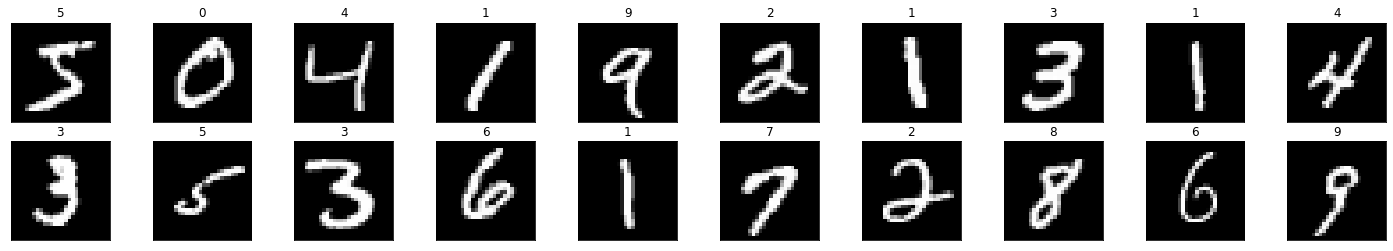

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
images, labels = train_images[:20], train_labels[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    ax.set_title(str(np.argmax(labels[idx])))

### View an Image in More Detail 

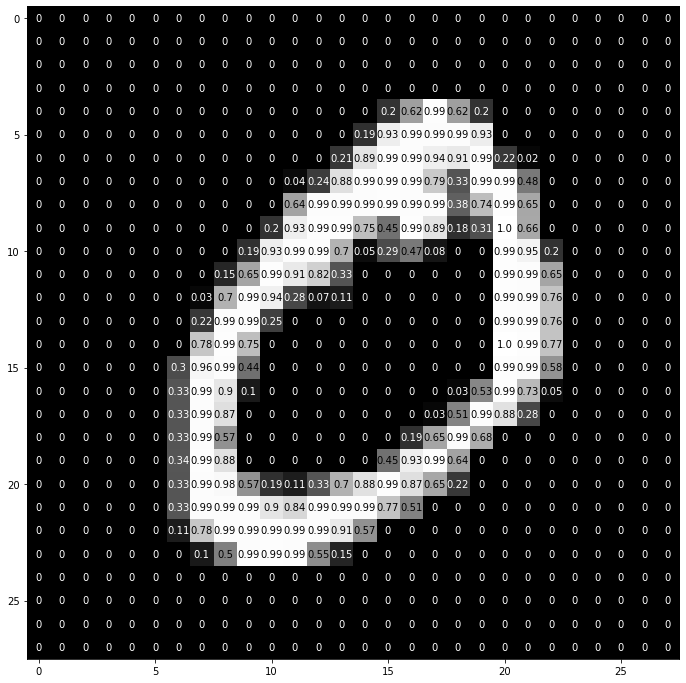

In [7]:
img = np.squeeze(train_images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [9]:
def define_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

In [10]:
model = define_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Compile and Train

In [11]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 33s 554us/sample - loss: 0.6088 - accuracy: 0.8443
Epoch 2/5
60000/60000 [==============================] - 33s 545us/sample - loss: 0.1768 - accuracy: 0.9473
Epoch 3/5
60000/60000 [==============================] - 31s 521us/sample - loss: 0.1122 - accuracy: 0.9662
Epoch 4/5
60000/60000 [==============================] - 31s 513us/sample - loss: 0.0846 - accuracy: 0.9737
Epoch 5/5
60000/60000 [==============================] - 31s 521us/sample - loss: 0.0702 - accuracy: 0.9773


## Test the Trained Network

Finally, we test our trained model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Test Accuracy: {:.4f} and Test Loss: {:.4f}'.format(test_acc, test_loss))

Test Accuracy: 0.9824 and Test Loss: 0.0545


In [14]:
def per_class_accuracy(model, test_images, test_labels):
    # initialize lists to monitor test accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    pred = model.predict(test_images, verbose=0)
    pred = np.argmax(pred, axis=-1)
    labels = np.argmax(test_labels, axis=-1)

    for i in range(len(pred)):
        correct = pred[i] == labels[i]
        class_correct[labels[i]] += correct
        class_total[labels[i]] += 1


    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))  

In [15]:
per_class_accuracy(model, test_images, test_labels)

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 97% (1008/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 97% (961/982)
Test Accuracy of     5: 97% (873/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 97% (1004/1028)
Test Accuracy of     8: 98% (961/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 98% (9824/10000)


Lets see predictions on individual test images. Since `model.predict` expects a batch of images, i.e, a 4-d tensor, we expand the first dimension of the test image before feeding into model.

Text(0.5, 1.0, 'Prediction: 7')

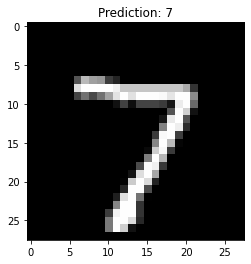

In [16]:
index = 0
pred = model.predict(np.expand_dims(test_images[index], axis=0)); pred = np.argmax(pred)
plt.imshow(np.squeeze(test_images[index]), cmap='gray')
plt.title('Prediction: {}'.format(pred))

In [17]:
#Define a python generator [More on Generators in cifar-10 notebook]
import itertools

def generator(images, labels, batch_size):
    iterable_1 = iter(images)
    iterable_2 = iter(labels)
    while True:
        l1 = tuple(itertools.islice(iterable_1, 0, batch_size))
        l2 = tuple(itertools.islice(iterable_2, 0, batch_size))
        if l1 and l2:
            yield np.vstack(np.expand_dims(l1, axis=0)), np.vstack(np.expand_dims(l2, axis=0))
        else:
            break
            
test_generator = generator(test_images, test_labels, 20)

In [18]:
def plot_predictions(test_generator, model):
    images, labels = next(test_generator)
    labels = np.argmax(labels, axis=-1)

    # get sample outputs
    preds = model.predict(images)
    # convert output probabilities to predicted class
    preds = np.argmax(preds, axis=-1)

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                     color=("green" if preds[idx]==labels[idx] else "red"))

/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


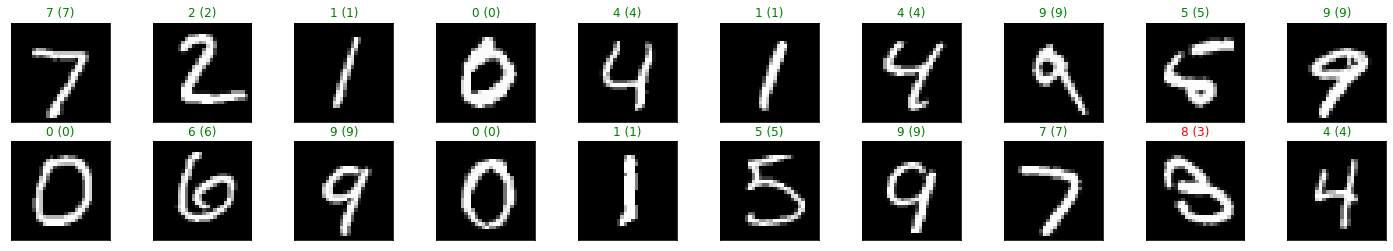

In [19]:
plot_predictions(test_generator, model)

In [20]:
def plot_incorrect_predictions(model, test_images, test_labels):
    # A sample of Incorrect Predictions
    preds = np.argmax(model.predict(test_images), axis=-1)
    labels = np.argmax(test_labels, axis=-1)
    incorrect_idxs = np.where( preds != labels )[0]

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for i in np.arange(20):
        idx = incorrect_idxs[i]
        ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                     color=("green" if preds[idx]==labels[idx] else "red"))

/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


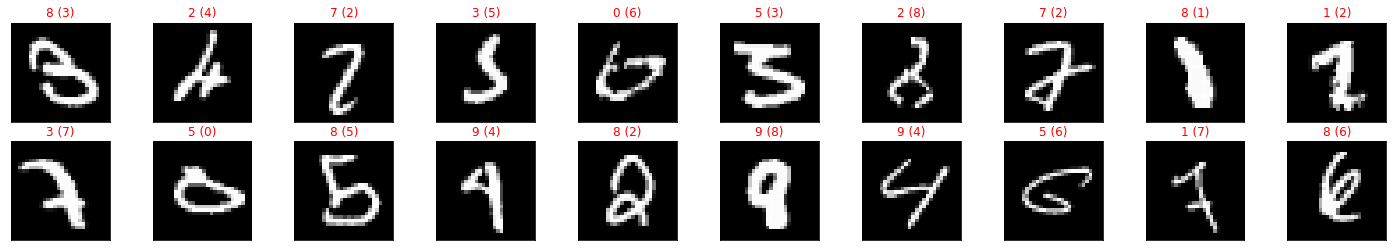

In [21]:
plot_incorrect_predictions(model, test_images, test_labels)

# Part 2: Translational invariance

People sometimes say that CNNs are invariant to translations, meaning that you can shift the pixels and get the same answer. This depends on the specific network and task but is roughly true. 

To be more specific, we can reference the definitions in the Sections 9.2 and 9.3 of the book *Deep Learning* by Goodfellow, et al., freely available [here](https://www.deeplearningbook.org/).

The parameter sharing in a convolutional layer makes the layer *equivariant* to translation: for example if you shift the image by 2 to the left and then apply the convolutional layer, the output is also shifted by 2 to the left.

In math: if *g* is a shifting function and the convolutional layer is called *f*, then f(g(x)) = g(f(x)).

Pooling layers are *invariant* to small translations: if you shift an image by 2 to the left and then apply the pooling layer, the output does not change.

In math: if g is a shifting function and the pooling layer is called f, then f(g(x)) = f(x). 

<img src="http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png" style="width: 600px;"/>

[src: [Deep Convolutional-Shepard Interpolation Neural Networks for Image Classification Tasks](https://link.springer.com/chapter/10.1007%2F978-3-319-93000-8_21)]

In [22]:
from scipy import ndimage

In [23]:
def compare_pair(original_image, transformed_image, model):
    pred1 = model.predict(np.expand_dims(original_image, axis=0)); pred1 = np.argmax(pred1)
    pred2 = model.predict(np.expand_dims(transformed_image, axis=0)); pred2 = np.argmax(pred2)

    fig = plt.figure(figsize=(17, 8))
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(original_image), cmap='gray')
    plt.title('Prediction: {} (Original Image)'.format(pred1))
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(transformed_image), cmap='gray')
    plt.title('Prediction: {} (Transformed Image)'.format(pred2))

In [24]:
def compare_with_shifting(index, right_shift, down_shift, model):
    original_image = test_images[index]
    shifted_image = ndimage.shift(original_image, shift=np.array([down_shift, right_shift, 0]), cval=0)
    compare_pair(original_image, shifted_image, model)

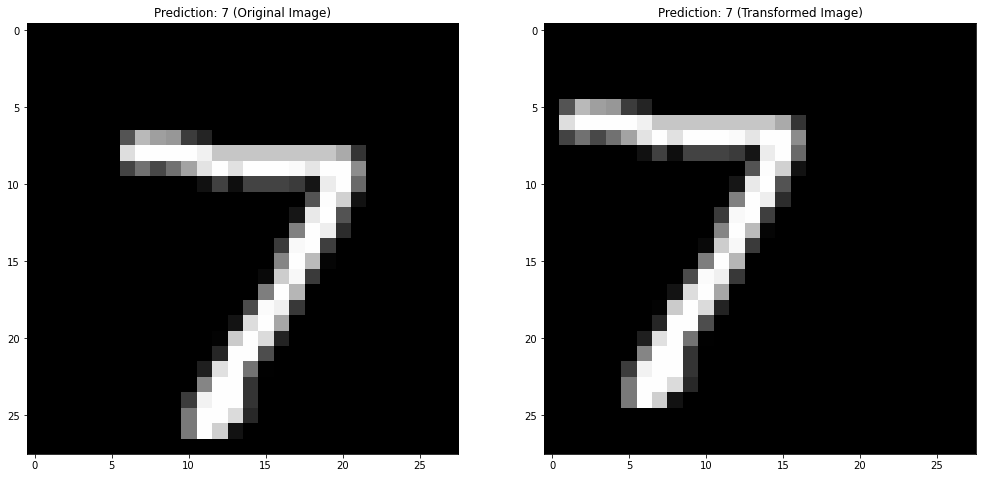

In [25]:
# example that works (at least with my trained model)
compare_with_shifting(index=0, right_shift=-5, down_shift=-2, model=model)

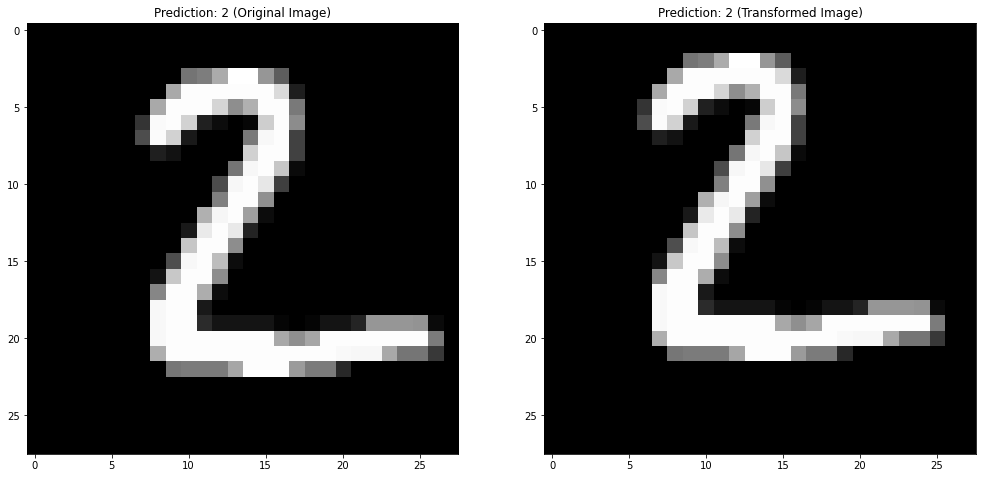

In [26]:
# small translation okay on this example (at least with my trained model)
compare_with_shifting(index=1, right_shift=-1, down_shift=-1, model=model)

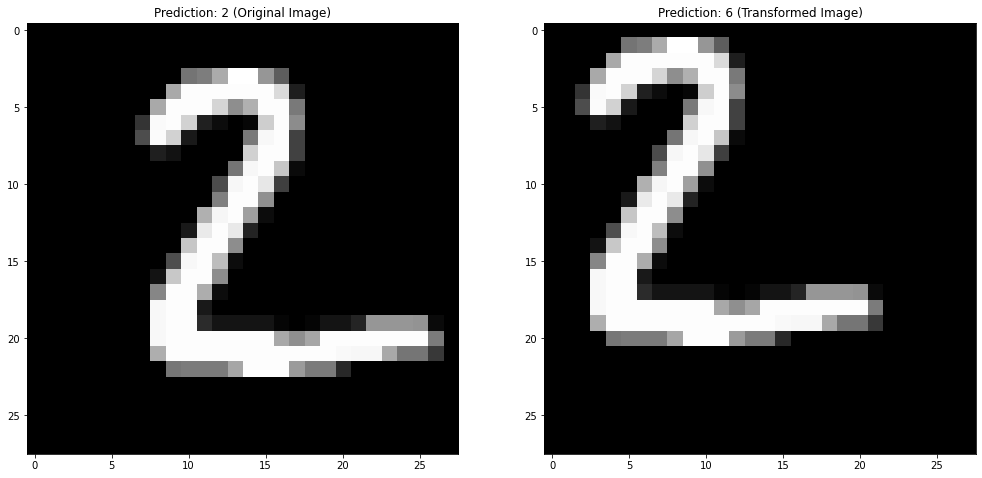

In [27]:
# but it's more fragile to bigger translations (at least with my trained model)
compare_with_shifting(index=1, right_shift=-5, down_shift=-2, model=model)

Here's an example paper that aims to address this:
Zhang, "Making Convolutional Networks Shift-Invariant Again" ICML 2019 ([paper](http://proceedings.mlr.press/v97/zhang19a/zhang19a.pdf), [code](https://github.com/adobe/antialiased-cnns))

# Part 3: Rotational invariance

Is a CNN robust to rotated images? There's no reason to expect it to be.

In [28]:
def compare_with_rotating(index, rotation, model):
    original_image = test_images[index]
    rotated_image = ndimage.rotate(original_image, angle=rotation, cval=0)
    compare_pair(original_image, rotated_image, model)

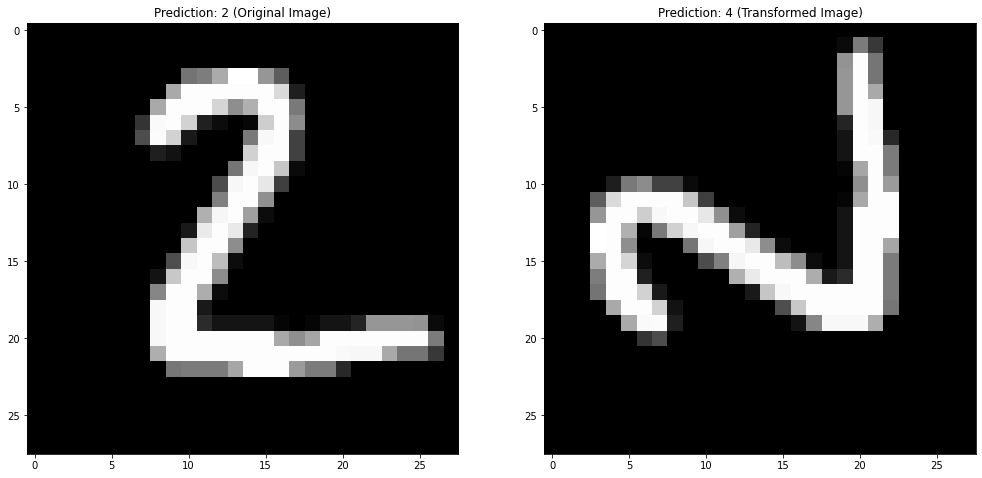

In [29]:
compare_with_rotating(index=1, rotation=90, model=model)

There are many recent papers on making versions of CNNs that are rotationally equivariant or invariant. Some examples are: 
* Cohen and Welling, "Group Equivariant Convolutional Networks" ICML 2016 ([paper](http://proceedings.mlr.press/v48/cohenc16.pdf), [code](https://github.com/tscohen/GrouPy))
* Worrall et al., "Harmonic Networks: Deep Translation and Rotation Equivariance" CVPR 2017 ([paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Worrall_Harmonic_Networks_Deep_CVPR_2017_paper.pdf), [code](https://github.com/danielewworrall/harmonicConvolutions))
* Weiler, Hamprecht, and Storath "Learning Steerable Filters for Rotation Equivariant CNNs" CVPR 2018 ([paper](https://openaccess.thecvf.com/content_cvpr_2018/papers/Weiler_Learning_Steerable_Filters_CVPR_2018_paper.pdf))
* Weiler and Cesa "General E(2)-Equivariant Steerable CNNs" NeurIPS 2019 ([paper](https://papers.nips.cc/paper/2019/file/45d6637b718d0f24a237069fe41b0db4-Paper.pdf), [code](https://github.com/QUVA-Lab/e2cnn))
* Romero, et al. "Attentive Group Equivariant Convolutional Networks" ICML 2020 ([paper](http://proceedings.mlr.press/v119/romero20a/romero20a.pdf), [code](https://github.com/dwromero/att_gconvs))
* Wang, et al. "Incorporating Symmetry into Deep Dynamics Models for Improved Generalization" ICLR 2021 ([paper](https://openreview.net/pdf?id=wta_8Hx2KD), [code](https://github.com/Rose-STL-Lab/Equivariant-Net))

However, for the purposes of this tutorial we will explore a simpler approach: augmenting the dataset with rotations.

In [30]:
def augment_data(images, labels):
    num_images = images.shape[0]
    augmented_images = np.concatenate((images, images), axis=0)
    augmented_labels = np.concatenate((labels, labels), axis=0)
    rotation_options = [90, 180, 270]
    for j in np.arange(num_images):
        rotation = rotation_options[np.random.randint(0,3)]
        augmented_images[j+num_images, :, :, :] = ndimage.rotate(images[j,:,:,:], angle=rotation, cval=0)
    shuffled_indices = np.random.permutation(augmented_images.shape[0])
    augmented_images = augmented_images[shuffled_indices, :, :, :]
    augmented_labels = augmented_labels[shuffled_indices, :]
    return augmented_images, augmented_labels

In [31]:
train_images_aug, train_labels_aug = augment_data(train_images, train_labels)

In [32]:
test_images_aug, test_labels_aug = augment_data(test_images, test_labels)

Note that this may be a tricky problem, even for humans, because, for example, an upside-down 6 can look like a 9. However, Rotated MNIST is a benchmark in many of the above papers. 

/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


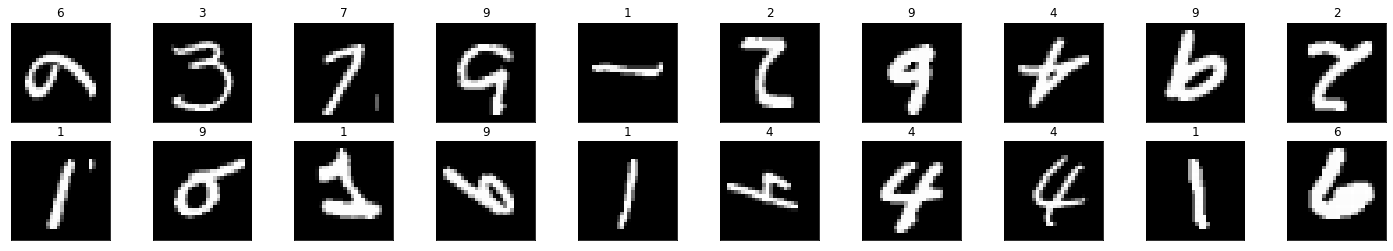

In [33]:
# obtain one batch of training images
images, labels = train_images_aug[:20], train_labels_aug[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    ax.set_title(str(np.argmax(labels[idx])))

In [34]:
# Let's use the same CNN architecture but retrain on this augmented dataset.
model2 = define_cnn()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [35]:
model2.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.fit(train_images_aug, train_labels_aug, epochs=5, batch_size=64)

Train on 120000 samples
Epoch 1/5
120000/120000 [==============================] - 65s 543us/sample - loss: 0.9720 - accuracy: 0.6947
Epoch 2/5
120000/120000 [==============================] - 61s 511us/sample - loss: 0.4225 - accuracy: 0.8702
Epoch 3/5
120000/120000 [==============================] - 60s 504us/sample - loss: 0.2885 - accuracy: 0.9121
Epoch 4/5
120000/120000 [==============================] - 60s 500us/sample - loss: 0.2240 - accuracy: 0.9308
Epoch 5/5
120000/120000 [==============================] - 60s 498us/sample - loss: 0.1839 - accuracy: 0.9429


## Testing the new network

In [36]:
test_loss, test_acc = model2.evaluate(test_images_aug, test_labels_aug, verbose=0)
print('Test Accuracy: {:.4f} and Test Loss: {:.4f}'.format(test_acc, test_loss))

Test Accuracy: 0.9516 and Test Loss: 0.1562


In [37]:
per_class_accuracy(model2, test_images_aug, test_labels_aug)

Test Accuracy of     0: 98% (1927/1960)
Test Accuracy of     1: 99% (2257/2270)
Test Accuracy of     2: 93% (1935/2064)
Test Accuracy of     3: 94% (1915/2020)
Test Accuracy of     4: 95% (1875/1964)
Test Accuracy of     5: 94% (1689/1784)
Test Accuracy of     6: 93% (1788/1916)
Test Accuracy of     7: 92% (1908/2056)
Test Accuracy of     8: 96% (1879/1948)
Test Accuracy of     9: 92% (1858/2018)

Test Accuracy (Overall): 95% (19031/20000)


/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


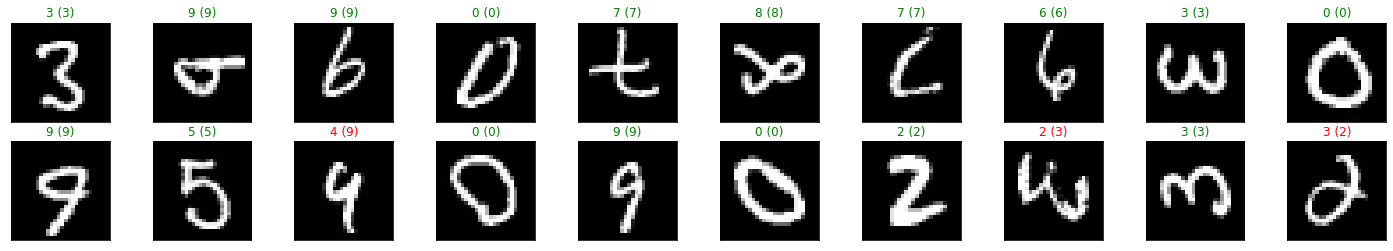

In [38]:
test_generator2 = generator(test_images_aug, test_labels_aug, 20)
plot_predictions(test_generator2, model2)

/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


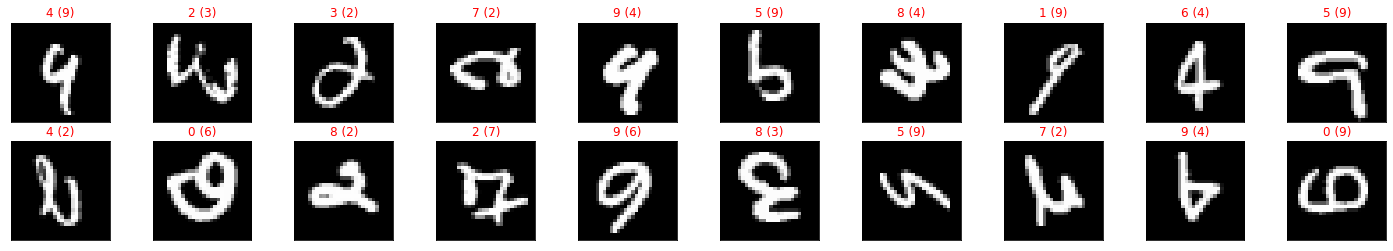

In [39]:
plot_incorrect_predictions(model2, test_images_aug, test_labels_aug)